# Improved WGAN

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
from tqdm import trange
from PIL import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the specified GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
!nvidia-smi

Sun Dec 19 00:58:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8    15W / 250W |     21MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

## Hyperparameters

In [4]:
SAMPLE_COL = 12
SAMPLE_ROW = 12
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 1000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BE = (BATCH_SIZE, IMG_H, IMG_W, IMG_C)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

# Improved WGAN
LAMBDA = 10
ALPHA = 0.0001
BETA1=0
BETA2=0.9

## Utility Functions

In [5]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

## Download Dataset

In [ ]:
## Download dataset from kaggle
## https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

!pip install --user kaggle
## Get kaggle.json file from kaggle.com/<USER_NAME>/account
## ...
!kaggle competitions download -c datalab-lab-14-2

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall('./dataset')

file_path = './dataset/datalab-lab-14-2.zip'
zip_list(file_path)

In [ ]:
## Extract .7z.*
!sudo apt-get install p7zip-full
!7z x img_align_celeba_png.7z.001
## System will automatically extract all img_align_celeba_png.7z.*

## Data Preprocess

Total image: 202599


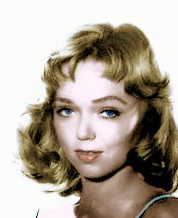

In [6]:
img_name = []
for i in range(1, 202600):
    name = f'./dataset/img_align_celeba_png/{i:06d}.png'
    img_name.append(name)
print('Total image:', len(img_name))
Image.open(img_name[202598])

Define mapping function and create dataset.

In [7]:
def map_fuc(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (64, 64))
    img = img / 255.
    return img

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((img_name))
dataset = dataset.map(
        map_fuc, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
dataset = dataset.shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

## Model

In [6]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In improved WGAN, I changed the optimizer from RMSProp to Adam. And weight clipping is not used anymore.<br>
* There is no change in WGTrain function.<br>
* In WDTrain function, I followed the algorithm and calculated gradient penalty term.

In [8]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(ALPHA, beta_1=BETA1, beta_2=BETA2)
optimizer_d = keras.optimizers.Adam(ALPHA, beta_1=BETA1, beta_2=BETA2)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(x):
    z = tf.random.normal(BZ)
    epsilon = tf.random.uniform(BE)

    with tf.GradientTape() as tpd:
        x_gen = WG(z, training = True)
        x_hat = epsilon * x + (1 - epsilon) * x_gen

        z_real = WD(x, training = True) # real img
        z_gen = WD(x_gen, training = True) # gen. img
        # z_hat = WD(x_hat, training = True)

        lg = tf.reduce_mean(z_gen)
        ld = tf.reduce_mean(z_real)
        with tf.GradientTape() as tpd_hat:
            tpd_hat.watch(x_hat)
            z_hat = WD(x_hat, training = True)
        gd = tpd_hat.gradient(z_hat, x_hat)
        norm_2 = tf.sqrt(tf.reduce_sum(gd ** 2)) # , axis=[1, 2]))
        lGP = tf.reduce_mean(LAMBDA * ((norm_2 - 1.0)**2))

        L = lg - ld + lGP

    gradient_d = tpd.gradient(L, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    
    # clipping
    # for v in WD.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [9]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

## Training

 12%|█▏        | 31/256 [56:14<6:23:47, 102.35s/it]

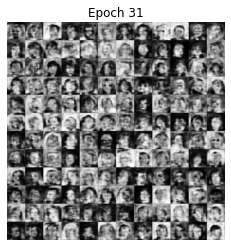

 25%|██▍       | 63/256 [1:50:51<5:29:23, 102.40s/it]

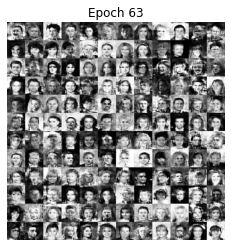

 37%|███▋      | 95/256 [2:45:29<4:34:45, 102.40s/it]

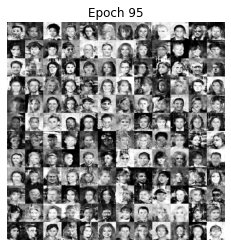

 50%|████▉     | 127/256 [3:40:10<3:40:31, 102.57s/it]

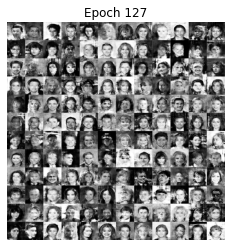

 62%|██████▏   | 159/256 [4:35:27<2:47:59, 103.92s/it]

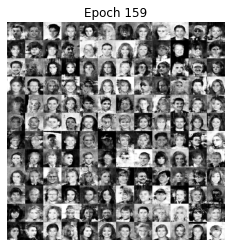

 75%|███████▍  | 191/256 [5:30:10<1:51:10, 102.63s/it]

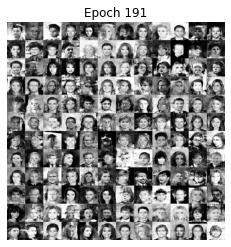

 87%|████████▋ | 223/256 [6:24:53<56:26, 102.61s/it]  

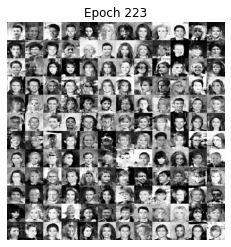

100%|█████████▉| 255/256 [7:19:38<01:42, 102.68s/it]

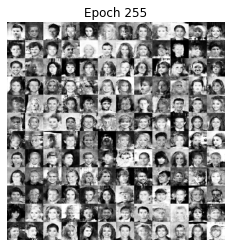

100%|██████████| 256/256 [7:21:21<00:00, 103.44s/it]


In [12]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(img_name))
ctr = 0
for ep in trange(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dataset:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/wgan-gp/wgan-gp_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

## Visualization

In [13]:
utMakeGif(np.array(wsp), "imgs/wgan-gp/wgan-gp.gif", duration = 2)

t:   1%|          | 2/256 [00:00<00:16, 15.08it/s, now=None]

MoviePy - Building file imgs/wgan-gp/wgan-gp.gif with imageio.


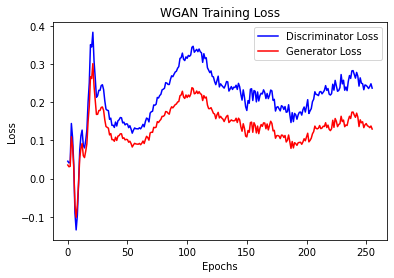

In [14]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

## MNIST Test

In [7]:
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 28
IMG_W = 28
IMG_C = 1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BE = (BATCH_SIZE, IMG_H, IMG_W, IMG_C)
BUF = 65536

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [8]:
# Load images, discard labels
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

In [9]:
WG_M, WD_M = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(ALPHA, beta_1=BETA1, beta_2=BETA2)
optimizer_d = keras.optimizers.Adam(ALPHA, beta_1=BETA1, beta_2=BETA2)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG_M(z, training = True)

        z1 = WD_M(c1, training = True)
        z0 = WD_M(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG_M.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG_M.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(x):
    z = tf.random.normal(BZ)
    epsilon = tf.random.uniform(BE)

    with tf.GradientTape() as tpd:
        x_gen = WG_M(z, training = True)
        x_hat = epsilon * x + (1 - epsilon) * x_gen

        z_real = WD_M(x, training = True) # real img
        z_gen = WD_M(x_gen, training = True) # gen. img
        # z_hat = WD(x_hat, training = True)

        lg = tf.reduce_mean(z_gen)
        ld = tf.reduce_mean(z_real)
        with tf.GradientTape() as tpd_hat:
            tpd_hat.watch(x_hat)
            z_hat = WD_M(x_hat, training = True)
        gd = tpd_hat.gradient(z_hat, x_hat)
        norm_2 = tf.sqrt(tf.reduce_sum(gd ** 2)) # , axis=[1, 2]))
        lGP = tf.reduce_mean(LAMBDA * ((norm_2 - 1.0)**2))

        L = lg - ld + lGP

    gradient_d = tpd.gradient(L, WD_M.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD_M.trainable_variables))
    
    # clipping
    # for v in WD.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [10]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

 12%|█▏        | 31/256 [02:13<15:41,  4.18s/it]

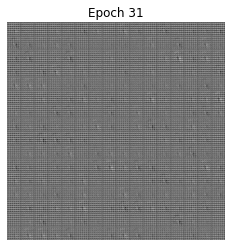

 25%|██▍       | 63/256 [04:27<13:32,  4.21s/it]

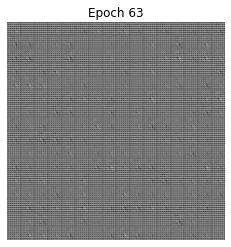

 37%|███▋      | 95/256 [06:42<11:16,  4.20s/it]

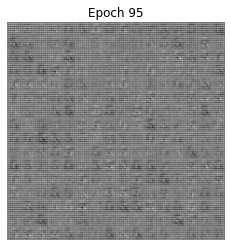

 50%|████▉     | 127/256 [09:15<13:50,  6.44s/it]

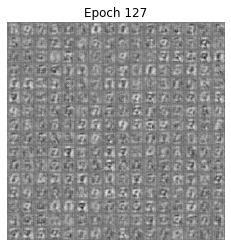

 62%|██████▏   | 159/256 [13:04<10:34,  6.54s/it]

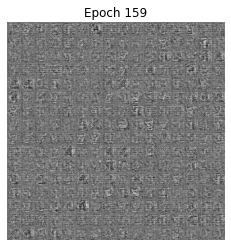

 75%|███████▍  | 191/256 [15:45<04:38,  4.28s/it]

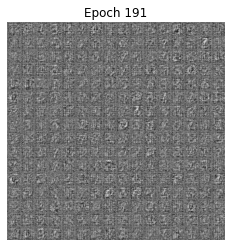

 87%|████████▋ | 223/256 [18:02<02:22,  4.31s/it]

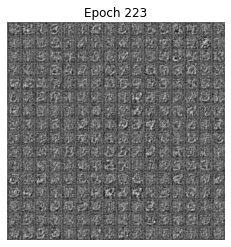

100%|█████████▉| 255/256 [20:18<00:04,  4.26s/it]

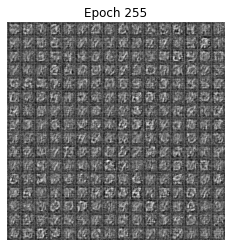

100%|██████████| 256/256 [20:22<00:00,  4.78s/it]


In [11]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in trange(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG_M(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/wgan-gp-mnist/wgan-gp-m_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [12]:
utMakeGif(np.array(wsp), "imgs/wgan-gp-mnist/wgan-gp-mnist.gif", duration = 2)

t:   0%|          | 0/256 [00:00<?, ?it/s, now=None]

MoviePy - Building file imgs/wgan-gp-mnist/wgan-gp-mnist.gif with imageio.


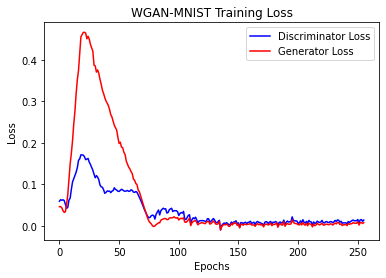

In [13]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-MNIST Training Loss")
plt.show()